In [1]:
# Thanks to Camille Rochefort-Boulanger for sharing this code with us!

import numpy as np
import pandas as pd
import torch.utils.data as tdata

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## DATA

In [3]:
root = '/content/gdrive/My Drive/Covid Project/'

In [4]:
# Load data
data = np.load(root + 'Copy of be_corrected_vaf_0.0.npy')

In [5]:
data = data.T

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=250)
transformed_data = pca.fit_transform(data)

In [7]:
transformed_data.shape

(29678, 250)

In [8]:
data = transformed_data

In [9]:
(data[4] == 0).mean()

0.0

In [10]:
data = (data - data.mean())/data.std()

# Targets

In [11]:
#targets = np.load(root + 'targets_2e-05.npy')
targets = np.load(root + 'Copy of targets_0.0001_0.0.npy')

In [12]:
targets.shape, data.shape

((29678,), (29678, 250))

In [13]:
class Covid19Dataset(tdata.Dataset):
  def __init__(self, vafs, target):
    super().__init__()
    self.vafs = vafs
    self.targets = targets.astype(np.float32)
    # self.seq_center = ...

  def __getitem__(self, idx):
    return self.vafs[idx], self.targets[idx] # self.seq_center[idx] ...
  def __len__(self):
    return len(self.targets)

In [14]:
mydata = Covid19Dataset(data, targets)

In [15]:
# create validation and test sets
from torch.utils.data import random_split

train, valid, test = random_split(mydata, [len(mydata)-10000, 5000, 5000])

In [16]:
train_data_loader = tdata.DataLoader(train, batch_size=64, num_workers=2, shuffle=True)
valid_data_loader = tdata.DataLoader(valid, batch_size=64, num_workers=2, shuffle=False)
test_data_loader = tdata.DataLoader(test, batch_size=64, num_workers=2, shuffle=False)

In [17]:
next(iter(train_data_loader))

[tensor([[-0.3418,  0.0442, -0.1443,  ...,  0.0060,  0.0215, -0.0046],
         [-0.2897, -0.0950, -0.0738,  ..., -0.0397, -0.0170, -0.0101],
         [-0.3152, -0.1129,  0.0055,  ..., -0.0427, -0.0223,  0.0303],
         ...,
         [-0.1720,  0.0866, -0.1124,  ...,  0.0391, -0.0144, -0.0545],
         [-0.2753,  0.1084, -0.1608,  ..., -0.0205, -0.0179, -0.0126],
         [-0.3452,  0.0361, -0.1547,  ..., -0.0084,  0.0018, -0.0024]],
        dtype=torch.float64),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
         0., 0., 1., 1., 1., 0., 0., 1., 1., 0.])]

In [18]:
from torch import nn as nn
from torch import optim

In [19]:
class Model(nn.Module):
  def __init__(self, in_feats, hidden_feats):
    super().__init__()
    self.l1 = nn.Linear(in_feats, hidden_feats)
    #self.act1 = nn.ReLU()
    #self.l2 = nn.Linear(hidden_feats, 1)
    #self.act2 = nn.ReLU()
    self.o = nn.Sigmoid()
  def forward(self, x):
    #x = self.act1(self.l1(x))
    #x = self.act2(self.l2(x))
    x = self.l1(x)
    return self.o(x)

In [20]:
model = Model(250, 1)

In [21]:
class Meter():
  def __init__(self):
    self.n = 0
    self.acc = 0
  
  def update(self, model_output, labels):
    self.n += model_output.shape[0]
    self.acc += ((out > 0.5) == labels).sum() 

  def compute_accuracy(self):
    return self.acc / self.n
  
  def reset_meter(self):
    self.n = 0
    self.acc = 0
  
  # Implement precision and recall here!

meter = Meter()

In [22]:
# initialize things needed for training!
# see docs for more details: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.001)  # alternative to SGD but easier to use! May want to use weight decay.

## Normal Loss

In [23]:
import torch
critereon = nn.BCELoss() # only difference from nn.CrossEntropyLoss is that this is binary (doesnt include sigmoid)

In [24]:
losses = []
accs = []
valid_accs = []

for e in range(25):
  meter.reset_meter()
  model.train()
  for i, (inp, tgt) in enumerate(train_data_loader):

    model.zero_grad()

    out = model(inp.float()).squeeze()
    meter.update(out.squeeze(), tgt)

    loss = critereon(out, tgt)
    loss.backward()
    optimizer.step()

    losses.append(loss.detach())
    #accs.append(100*meter.compute_accuracy())

    #if ((i % 400) == 0) & (i > 0):
    #  print('{} [{}/{}] loss: {:.2f} Acc: {:.2f}%'.format(e, i, len(my_data_loader), loss.item(), 100*meter.compute_accuracy()))
  accs.append(100*meter.compute_accuracy())
  print('{} [{}/{}] loss: {:.2f} Acc: {:.2f}%'.format(e, i, len(train_data_loader), loss.item(), 100*meter.compute_accuracy()))

  meter.reset_meter()
  model.eval()
  for i, (inp, tgt) in enumerate(valid_data_loader):

    out = model(inp.float()).squeeze()
    meter.update(out.squeeze(), tgt)

  valid_accs.append(100*meter.compute_accuracy())
  print('{} [{}/{}] Valid Acc: {:.2f}%'.format(e, i, len(valid_data_loader), 100*meter.compute_accuracy()))

0 [307/308] loss: 0.63 Acc: 78.52%
0 [78/79] Valid Acc: 78.28%
1 [307/308] loss: 0.53 Acc: 79.97%
1 [78/79] Valid Acc: 78.28%
2 [307/308] loss: 0.82 Acc: 80.18%
2 [78/79] Valid Acc: 78.46%
3 [307/308] loss: 0.41 Acc: 80.29%
3 [78/79] Valid Acc: 78.46%
4 [307/308] loss: 0.46 Acc: 80.37%
4 [78/79] Valid Acc: 78.44%
5 [307/308] loss: 0.63 Acc: 80.45%
5 [78/79] Valid Acc: 78.44%
6 [307/308] loss: 3.74 Acc: 80.42%
6 [78/79] Valid Acc: 78.46%
7 [307/308] loss: 0.52 Acc: 80.45%
7 [78/79] Valid Acc: 78.54%
8 [307/308] loss: 0.51 Acc: 80.44%
8 [78/79] Valid Acc: 78.56%
9 [307/308] loss: 0.51 Acc: 80.45%
9 [78/79] Valid Acc: 78.58%
10 [307/308] loss: 0.54 Acc: 80.51%
10 [78/79] Valid Acc: 78.62%
11 [307/308] loss: 0.45 Acc: 80.48%
11 [78/79] Valid Acc: 78.66%
12 [307/308] loss: 0.49 Acc: 80.47%
12 [78/79] Valid Acc: 78.66%
13 [307/308] loss: 0.49 Acc: 80.42%
13 [78/79] Valid Acc: 78.70%
14 [307/308] loss: 0.57 Acc: 80.48%
14 [78/79] Valid Acc: 78.72%
15 [307/308] loss: 0.59 Acc: 80.44%
15 [78/79

In [25]:
meter.reset_meter()
model.eval()
test_preds = []
true_labels = []
for i, (inp, tgt) in enumerate(test_data_loader):

  out = model(inp.float()).squeeze()
  test_preds.extend((out > 0.5))
  true_labels.extend(tgt.tolist())
  meter.update(out.squeeze(), tgt)

valid_accs.append(100*meter.compute_accuracy())
print('[{}/{}] Valid Acc: {:.2f}%'.format(i, len(valid_data_loader), 100*meter.compute_accuracy()))

[78/79] Valid Acc: 79.06%


In [43]:
# compute precision/recall of test data!
# for AUC try this out: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

test_preds = np.array(test_preds)
true_labels = np.array(true_labels)

print(test_preds)
print(true_labels)
print(test_preds == true_labels)
print((test_preds == true_labels).sum())
print((test_preds == true_labels).mean())
print(test_preds.sum())
print(true_labels.sum())
print(true_labels.astype('bool'))
print(True & True)
print((test_preds & true_labels.astype('bool')))
print((test_preds & true_labels.astype('bool')).sum())
# precision =  (+ve and predicted +ve) / (predicted +ve)
# recall = (+ve and predicted +ve) / (+ve)

[False False False ... False False False]
[0. 0. 0. ... 0. 0. 0.]
[ True  True  True ...  True  True  True]
3953
0.7906
34
1037.0
[False False False ... False False False]
True
[False False False ... False False False]
12


In [27]:
print((test_preds == true_labels).mean()) # accuracy
print((test_preds & true_labels.astype('bool')).sum() / test_preds.sum())  # precision
print((test_preds & true_labels.astype('bool')).sum() / true_labels.sum())  # recall

0.7906
0.35294117647058826
0.011571841851494697


## Network Training Diagnostics

Training curve: plotting accuracy and training loss against # steps performed

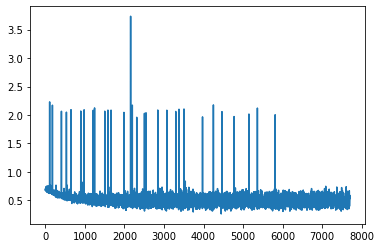

In [28]:
import matplotlib.pyplot as plt

plt.plot(losses)

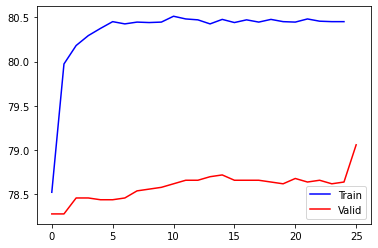

In [29]:
plt.plot(accs, color='blue', label='Train')
plt.plot(valid_accs, color='red', label='Valid')
plt.legend()

Inspecting Model outputs

Plot model weight distribution

In [30]:
model.l1.weight.detach().numpy().squeeze().mean()

-0.009072273

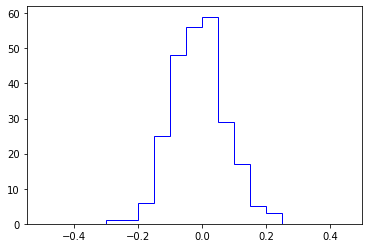

In [31]:
_ = plt.hist(model.l1.weight.detach().numpy().squeeze().flatten(), bins=np.arange(-0.5, 0.5, 0.05), color='blue', histtype='step')

In [32]:
model.l1.bias

Parameter containing:
tensor([-1.3801], requires_grad=True)

What things are we missing here?

* Handle unbalanced dataset ? (X)
* regularization (e.g. dropout, early stopping, L2) (We did L2, try early stopping or dropout)
* Validation set, test set! (X)
* meter is only computing accuracy ! Maybe we do Precision and Recall ?
* plot the loss curve over time! (X)

## Weighted Loss Function

In [33]:
import torch
critereon = nn.BCELoss(reduction='none')

In [34]:
weight=torch.tensor([targets.mean(), 1/targets.mean()], dtype=torch.float32)

In [35]:
for e in range(5):
  meter.reset_meter()
  model.train()
  for i, (inp, tgt) in enumerate(train_data_loader):
    out = model(inp.float()).squeeze()
    meter.update(out, tgt)

    # make weights
    weight = [1,10]
    loss = critereon(out, tgt)
    batch_weights = torch.zeros_like(tgt)
    batch_weights[tgt == 0] = weight[0]
    batch_weights[tgt == 1] = weight[1]
    loss = loss.mean()

    loss.backward()
    optimizer.step()
    if i % 50 == 0:
      print('{} [{}/{}] loss: {:.2f} Acc: {:.2f}%'.format(e, i, len(train_data_loader), loss.item(), 100*meter.compute_accuracy()))

      

0 [0/308] loss: 0.43 Acc: 84.38%
0 [50/308] loss: 0.59 Acc: 80.88%
0 [100/308] loss: 0.71 Acc: 80.06%
0 [150/308] loss: 0.50 Acc: 80.08%
0 [200/308] loss: 0.50 Acc: 80.05%
0 [250/308] loss: 1.87 Acc: 79.65%
0 [300/308] loss: 0.53 Acc: 79.66%
1 [0/308] loss: 0.83 Acc: 76.56%
1 [50/308] loss: 0.61 Acc: 79.72%
1 [100/308] loss: 0.43 Acc: 79.89%
1 [150/308] loss: 0.56 Acc: 79.71%
1 [200/308] loss: 2.24 Acc: 79.75%
1 [250/308] loss: 0.51 Acc: 79.60%
1 [300/308] loss: 0.57 Acc: 79.42%
2 [0/308] loss: 0.51 Acc: 81.25%
2 [50/308] loss: 1.97 Acc: 79.84%
2 [100/308] loss: 0.68 Acc: 79.35%
2 [150/308] loss: 0.40 Acc: 79.43%
2 [200/308] loss: 0.70 Acc: 79.24%
2 [250/308] loss: 0.56 Acc: 79.25%
2 [300/308] loss: 0.50 Acc: 79.16%
3 [0/308] loss: 0.51 Acc: 82.81%
3 [50/308] loss: 0.46 Acc: 77.76%
3 [100/308] loss: 0.64 Acc: 78.12%
3 [150/308] loss: 0.73 Acc: 78.76%
3 [200/308] loss: 0.63 Acc: 79.07%
3 [250/308] loss: 0.65 Acc: 79.02%
3 [300/308] loss: 0.55 Acc: 79.03%
4 [0/308] loss: 2.25 Acc: 70.31%